In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import interpolate
from scipy.stats import zscore

# Load geospatial data
S = gpd.read_file('job_LAM12092019_corrected_14092019_MERGE.shp')

# Assign columns to variables
X = S['Crrctd_X']
Y = S['Crrctd_Y']
Z = S['Z_Elevatio']
pp = S['Point'].astype(float)

idx = 333
Za = Z.copy()
Za[idx:] = Za[idx:] - 0.2
TF = np.abs(zscore(Za)) > 3

id11 = np.where((X==1.016840383320000e+03) & (Y==9.273267338000000e+02))
id22 = np.where((X==1.023083000000000e+03) & (Y==9.324720000000000e+02))
id3 = np.where((X==1.015938837640000e+03) & (Y==9.293073792480000e+02))
id4 = np.where((X==1.023988234840000e+03) & (Y==9.290105801640000e+02))

Za[id3[0][0]:id4[0][0]] = np.nan
Za[id11[0]] = np.nan
Za[id22[0]] = np.nan

tmpX1, tmpX3 = np.unique(X, return_inverse=True)
tmpY1, tmpY3 = np.unique(Y, return_inverse=True)
Xi, Yi = np.meshgrid(tmpX1,tmpY1)
tmpZ = np.ravel_multi_index((tmpY3,tmpX3), Xi.shape)

Zi = np.full(Xi.shape, np.nan)
Zi.flat[tmpZ] = Za

# Inpaint NaN values using interpolation
valid_mask = ~np.isnan(Zi)
coords = np.array(np.nonzero(valid_mask)).T
values = Zi[valid_mask]
it = interpolate.LinearNDInterpolator(coords, values, fill_value=np.nan)
Zin = it(list(np.ndindex(Zi.shape))).reshape(Zi.shape)

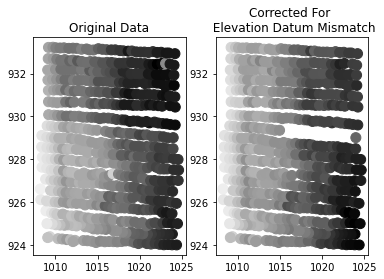

In [2]:
# Plotting Raw Data showing before and after correction
plt.figure()
plt.subplot(121)
plt.scatter(X,Y,c=Z, s=100,cmap='gray_r')
plt.title('Original Data')
plt.subplot(122)
plt.scatter(X,Y,c=Za, s=100,cmap='gray_r')
plt.title('Corrected For \n Elevation Datum Mismatch')

plt.show()

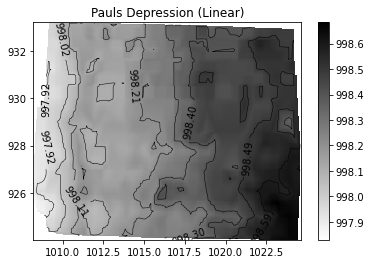

In [12]:
# Plot Linearly Interpolated Data
plt.figure()
plt.pcolormesh(Xi, Yi, Zin, cmap='gray_r')
plt.colorbar()
# Add contours
levels = np.linspace(np.nanmin(Zin), np.nanmax(Zin), 10)  # Adjust the number of levels as needed
cs = plt.contour(Xi, Yi, Zin, levels=levels, colors='black', linewidths=0.5)
# Add contour labels
fmt = '%.2f'  # Format contour labels to 2 decimal places
plt.clabel(cs, inline=1, fontsize=10, fmt=fmt)
plt.title('Pauls Depression (Linear)')
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'power' Variogram Model
Scale: 0.0007294152127236209
Exponent: 1.9989999999998636
Nugget: 5.746305229631907e-22 



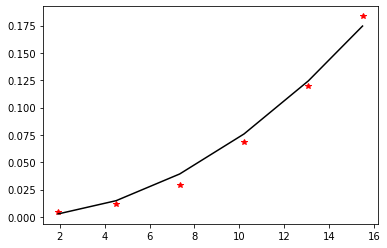

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [20]:
# Get 1D arrays of grid coordinates
Xgrid, Ygrid = Xi.flatten(), Yi.flatten()

# Mask these arrays with valid_mask
X_valid = Xgrid[valid_mask.flatten()]
Y_valid = Ygrid[valid_mask.flatten()]
Z_valid = Zi[valid_mask]

from pykrige.ok import OrdinaryKriging

# Create an Ordinary Kriging object
OK = OrdinaryKriging(
    X_valid, Y_valid, Z_valid,
    variogram_model='power', 
    verbose=True, 
    enable_plotting=True)

# Apply the kriging algorithm to your grid
Zin2, ss = OK.execute('grid', tmpX1, tmpY1)

# The kriging grid is returned as a 2D array (Zin), and we can convert it to our original shape
Zin2 = Zin2.data


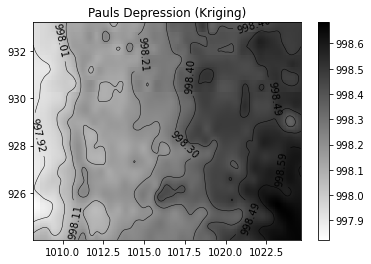

In [21]:
plt.figure()
plt.pcolormesh(Xi, Yi, Zin2, cmap='gray_r')
plt.colorbar()
# Add contours
levels = np.linspace(Zin2.min(), Zin2.max(), 10)  # Adjust the number of levels as needed
cs = plt.contour(Xi, Yi, Zin2, levels=levels, colors='black', linewidths=0.5)
# Add contour labels
fmt = '%.2f'  # Format contour labels to 2 decimal places
plt.clabel(cs, inline=1, fontsize=10, fmt=fmt)
plt.title('Pauls Depression (Ordinary Kriging)')
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'power' Variogram Model
Scale: 0.0007294152127236209
Exponent: 1.9989999999998636
Nugget: 5.746305229631907e-22 



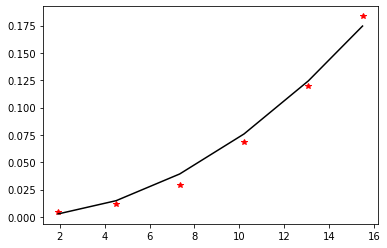

Calculating statistics on variogram model fit...
Q1 = 0.9827166481373636
Q2 = 5434.75788000727
cR = 0.0018684787486114847 

Initializing drift terms...
Implementing regional linear drift.
Executing Universal Kriging...



In [25]:
from pykrige.uk import UniversalKriging

# Create an Universal Kriging object
UK = UniversalKriging(
    X_valid, Y_valid, Z_valid,
    variogram_model='power',  # Using the power model
    drift_terms=['regional_linear'],  # Adding a regional linear drift
    verbose=True, 
    enable_plotting=True)

# Apply the kriging algorithm to your grid
Zin3, ss = UK.execute('grid', tmpX1, tmpY1)

# The kriging grid is returned as a 2D array (Zin), and we can convert it to our original shape
Zin3 = Zin3.data

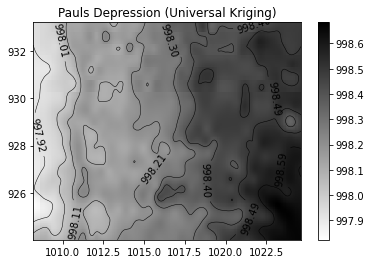

In [24]:
plt.figure()
plt.pcolormesh(Xi, Yi, Zin3, cmap='gray_r')
plt.colorbar()
# Add contours
levels = np.linspace(Zin3.min(), Zin3.max(), 10)  # Adjust the number of levels as needed
cs = plt.contour(Xi, Yi, Zin3, levels=levels, colors='black', linewidths=0.5)
# Add contour labels
fmt = '%.2f'  # Format contour labels to 2 decimal places
plt.clabel(cs, inline=1, fontsize=10, fmt=fmt)
plt.title('Pauls Depression (Universal Kriging)')
plt.show()

In [6]:
'''

import plotly.graph_objects as go


fig = go.Figure(data=[go.Surface(x=Xi, y=Yi, z=Zin, colorscale="Greys", reversescale=False)])

fig.update_layout(title='Pauls Depression', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.update_layout(scene = dict(
                    xaxis = dict(nticks=4, range=[1005,1025],),
                    yaxis = dict(nticks=4, range=[924,934],),
                    zaxis = dict(nticks=4, range=[997,1000],),
                    camera = dict(
                        up=dict(x=0, y=0, z=1),
                        center=dict(x=0, y=0, z=0),
                        eye=dict(x=-1.5, y=-1.5, z=+0.1)
                    )))


fig.show()
'''


'\n\nimport plotly.graph_objects as go\n\n\nfig = go.Figure(data=[go.Surface(x=Xi, y=Yi, z=Zin, colorscale="Greys", reversescale=False)])\n\nfig.update_layout(title=\'Pauls Depression\', autosize=False,\n                  width=500, height=500,\n                  margin=dict(l=65, r=50, b=65, t=90))\n\nfig.update_layout(scene = dict(\n                    xaxis = dict(nticks=4, range=[1005,1025],),\n                    yaxis = dict(nticks=4, range=[924,934],),\n                    zaxis = dict(nticks=4, range=[997,1000],),\n                    camera = dict(\n                        up=dict(x=0, y=0, z=1),\n                        center=dict(x=0, y=0, z=0),\n                        eye=dict(x=-1.5, y=-1.5, z=+0.1)\n                    )))\n\n\nfig.show()\n'